## AIM: Try to build a NN with Tensorflow 2.x that will predict the incoming pitches given the various features within the dataframe.

***

**NOTE:** The code here uses `TensorFlow 2.0`. The code in building the layers is very different than that of TensorFlow 1.0.

I gravitated towards utilizing neural networks for this project because of the number of features in the dataset, I hypothesized NNs will perform better than simpler models. I also wanted to learn more and gain practical experience working the neural networks and TensorFlow/Keras.

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Reading in this df will take some time given its size
df = pd.read_csv('pitches_final_simplified.csv', index_col = 0)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.head()

,game_date,release_speed,player_name,description,zone,type,balls,strikes,plate_x,plate_z,...,pitch_name,bat_score,fld_score,reg_season,post_season,p_left,p_right,bat_left,bat_right,prev_pitch
0,2015-04-05,90.1,Adam Wainwright,ball,13,B,0,0,-1.585,1.720,...,Fastball,0,1,1,0,0,1,1,0,None
1,2015-04-05,88.1,Adam Wainwright,hit_into_play_no_out,5,X,1,0,0.008,2.602,...,Fastball,0,1,1,0,0,1,1,0,Fastball
2,2015-04-05,92.2,Adam Wainwright,foul,5,S,0,0,0.015,2.287,...,Fastball,0,1,1,0,0,1,0,1,None
3,2015-04-05,76.6,Adam Wainwright,blocked_ball,14,B,0,1,1.703,0.220,...,Breaking Ball,0,1,1,0,0,1,0,1,Fastball
4,2015-04-05,89.9,Adam Wainwright,hit_into_play,9,X,1,2,0.788,1.808,...,Fastball,0,1,1,0,0,1,0,1,Breaking Ball


In [5]:
# Get a subset for a particular player to begin with
kershaw = df[df['player_name']=='Max Scherzer']

In [6]:
# Naturally expect a class imbalance for pitchers
kershaw['pitch_name'].value_counts()

Fastball         9910
Breaking Ball    4758
Off-speed        2389
Name: pitch_name, dtype: int64

Here we have the first issue with classifying pitches, not all pitches are created equal. Naturally, the fastball is the most commonly used pitch for just about ALL pitchers. Breaking balls and off-speed pitch usage will vary with the pitcher.

Here, I decided to go ahead without making adjustments to the class distributions to test out how the model will perform.
***

In [7]:
# For the sake of streamlining (and anticipation of trying to automate it through looping later on)
# I combined a lot of the pre-processing code into this one block

# Drop intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')

# Unable to classify/do regression with classes with only 1 instance
# so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
for i in range(len(kershaw['pitch_name'].value_counts())):
    if kershaw['pitch_name'].value_counts()[i] == 1:
        drop = kershaw['pitch_name'].value_counts().index[i]
        kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
        kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

# Do not need the game data anymore
# Description can be useful if incorporated down the line for increasing complexity but right now it's not needed
kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

# Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
kershaw.drop(['release_speed'], axis = 1, inplace = True)

# Drop other non pre-pitch predicative stuff
kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)
kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


***

Upon thinking about the `Balls` and `Strikes` columns, I decided that it is most appropriate to one-hot-encode these variables. Even though they are numeric columns encoding for integer values, the values themselves are distinct rather than continuous.

In baseball, there is a balls-strike count. A `ball` is a pitch that falls outside the "strike zone", while a `strike` is a pitch that is within the strike zone or outside and the batter either swings and misses at or swings and does not put into play.

The balls-strike count is important in pitching as a max of 4 balls can be thrown to a batter before they are given a free pass, called a `walk` or `base on balls`, to go on the bases. A max of 3 strikes need to be thrown for the batter to be struckout. 

Therefore, pitchers will tend to throw pitches they have better control with as the number of balls increases and conversely, throw pitches that are more deceptive when they have more strikes, in hopes of getting the batter to swing and miss.

While a scenario with 3 balls has 3x more than a scenario with just 1 ball, the importance of having 3 balls is not necessary greater than having 1 ball. 

Each are distinct entities and I decided that it would be most correct to treat it as a categorical column and one-hot-encoding it, effectively making all possible situations (0/1/2/3 balls or 0/1/2 strikes) equal in weight. 

This turns the question asked by the model from <i>"is there 3x more balls than a 1 ball situation"</i> to <i>"is this a 3 ball situation instead of a 1 ball situation"</i>, which is the more appropriate question given this problem space.

I also wanted to address a similar issue for the `inning` column. There are 9 innings in a baseball game and the values are encoded as integers from 1-9, but again, it is more categorical than numeric. For the sake of simplicity, I also decided to convert the 9 possible innings values to 3 - **early (1-3) / mid (4-6) / late (7-9)**. 

These values denote whether it is the early game, mid game or late game (end game). Since this fully transforms the `inning` column to a categorical one, I also went ahead and one-hot encoded it.

In [8]:
# Get dummies for balls and strikes, add a prefix because they are just 1s, 2s etc and are the same
balls = pd.get_dummies(kershaw['balls'], prefix = 'b_', drop_first = True)
strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_', drop_first = True)
# Get dummies for the previous pitch column, since it is categorical
prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_', drop_first = True)
# Combine the dummie variable matrices, assign them all to the X variable
X = pd.concat([kershaw, balls, strikes, prev], axis = 1)
# Drop the originals now
X.drop(['balls', 'strikes', 'prev_pitch'], axis = 1, inplace = True)

# Drop the location of the top/bot of the strikezone, not useful down the line
# While it may be useful as pitchers may throw differently to tall/short batters, this is not inputable info for an user
X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

# Convert innings to either early/mid/late and write them as dummie/one-hot-encoded columns
X['early'] = np.where(X['inning'] <= 3, 1, 0)
X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)
# Drop original inning column
X.drop(['inning'], axis = 1, inplace = True)

# Drop the pitch number of the at bat, it may be a useful feature later on, but for now I won't use it
X.drop(['pitch_number'], axis = 1, inplace = True)
# Also drop what zone of the strike zone the pitch is, this is info AFTER the pitch is thrown and therefore not useful
X.drop(['zone'], axis = 1, inplace = True)

In [9]:
# X will be all the features minus the pitch name which is the target
X1 = X.drop(['pitch_name'], axis = 1)
# Set the target variable
y = X['pitch_name']

In [10]:
from sklearn.model_selection import train_test_split

# Split with stratification given the class imbalance
X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25)

In [11]:
print(y_train.value_counts())
print(y_test.value_counts())

Fastball         7432
Breaking Ball    3568
Off-speed        1792
Name: pitch_name, dtype: int64
Fastball         2478
Breaking Ball    1190
Off-speed         597
Name: pitch_name, dtype: int64


In [12]:
# Convert output to an array for the NN
pitch = pd.get_dummies(y_train.copy())
y_train = pitch.values

In [13]:
# Same with y_test
pitch = pd.get_dummies(y_test.copy())
y_test = pitch.values

In [14]:
# Verify everything lines up in terms of dimension
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12792, 26)
(12792, 3)
(4265, 26)
(4265, 3)


After playing around quite a bit with hyperparameters, optimizer types, and overwriting/over-running the various cells below, I settled on the `Adam` optimizer with a learning rate of `0.0001` to work the best. I also tried `SGD` and various other hyperparameters but given that the cells below were overwritten by running them again multiple time (it just wasn't practical to have new cells for each attempt, it would have been a total mess!), these results are not present here in this notebook.

In [15]:
# Define the NN optimizer
opt = tf.keras.optimizers.Adam(lr=0.0001)

In [395]:
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum = 0.9, nesterov = False)

***
Similar case with the layer compostion of the neural network. I built a relatively simple feed-forward NN that is largely composed of a repeating pattern of a dense layer and a dropout layer. I found that overfitting was very much an issue with my NN and the addition of dropout layers between the various dense layers helped improve accuracy and dealt with the overfitting problem.

Optimizing layer hyperparameters and layer composition continues to be mostly trial and error. I couldn't find any good previously built models with similar aims compared to mine to conduct transfer learning with.

After trying different values, I settled on 30 epochs for now because it was the largest number of epochs before the model began overfitting to the training data as seen by the divergence in the training and validation losses. Unfortunately, each epoch only made marginal improvements to the overall accuracy.

In [84]:
# Make sure to reset model before running each time
# Set the input shape to be equal to the number of X_train columns
input_layer = Input(shape = (X_train.shape[1], ))

dense_layer_1 = Dense(512, activation='relu')(input_layer)
drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)

dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)

dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)

dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)

# Output shape equals to number of classes (columns) in y
output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
# Define the loss function to be categorical cross entropy (ie. incorrect classifications) 
# Metric of interest is accuracy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

# Fit the model to the training set @ 30 epochs, do a validation split of 0.2
history = model.fit(X_train, y_train, batch_size=25, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
286/286 [==============================] - 1s 5ms/step - loss: 0.9731 - acc: 0.4993 - val_loss: 1.1668 - val_acc: 0.2514
Epoch 2/30
286/286 [==============================] - 1s 4ms/step - loss: 0.9394 - acc: 0.5214 - val_loss: 1.1185 - val_acc: 0.4339
Epoch 3/30
286/286 [==============================] - 1s 4ms/step - loss: 0.9301 - acc: 0.5336 - val_loss: 1.1948 - val_acc: 0.2548
Epoch 4/30
286/286 [==============================] - 1s 4ms/step - loss: 0.9274 - acc: 0.5343 - val_loss: 1.1144 - val_acc: 0.3886
Epoch 5/30
286/286 [==============================] - 2s 6ms/step - loss: 0.9185 - acc: 0.5374 - val_loss: 1.1302 - val_acc: 0.3869
Epoch 6/30
286/286 [==============================] - 1s 4ms/step - loss: 0.9197 - acc: 0.5374 - val_loss: 1.1558 - val_acc: 0.3852
Epoch 7/30
286/286 [==============================] - 1s 3ms/step - loss: 0.9185 - acc: 0.5339 - val_loss: 1.1249 - val_acc: 0.3891
Epoch 8/30
286/286 [==============================] - 1s 4ms/step - loss: 0.

In [85]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               13824     
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0   

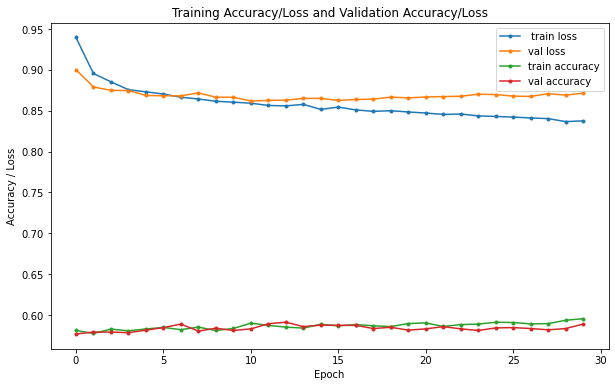

In [17]:
# Visualize train/val loss/accuracy over epochs to monitor for overfitting
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.show()

In [18]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

134/134 [==============================] - 0s 2ms/step - loss: 0.8880 - acc: 0.5749
Test Loss: 0.8879958987236023
Test Accuracy: 0.5749120712280273


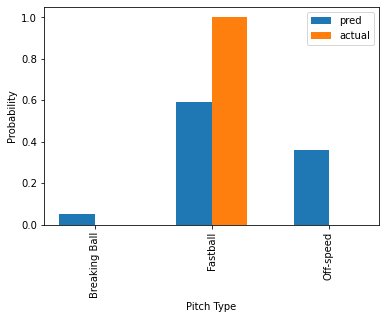

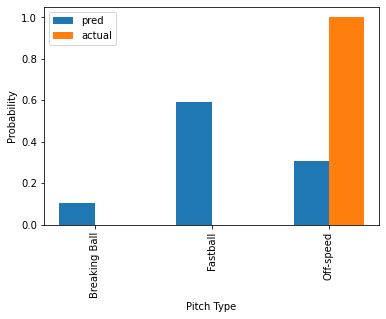

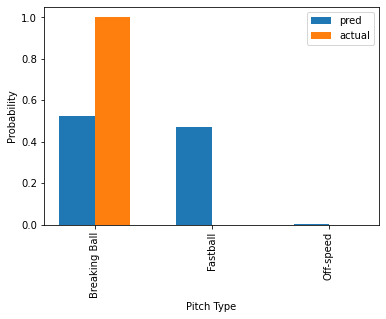

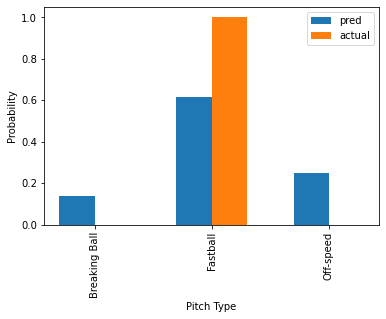

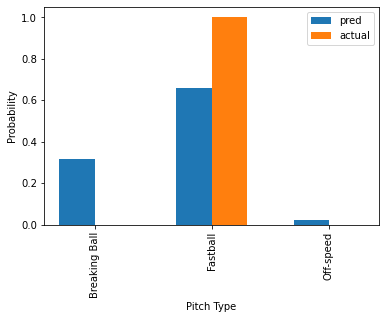

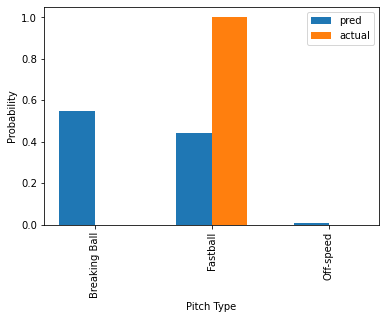

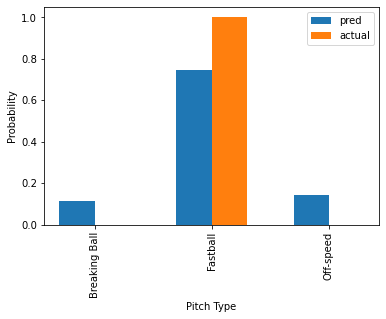

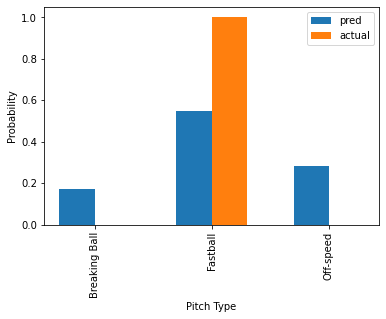

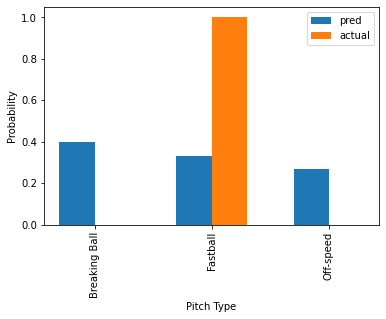

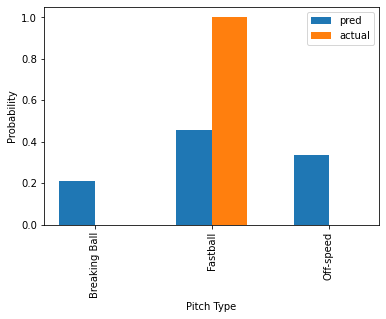

In [25]:
# Just get the probability and plot them out vs what the actual pitch was
# Get an idea of what the model is predicting
predictions = model.predict(X_test)

xnames = pitch.columns

indices = np.arange(len(pitch.columns))
width = 0.3

for i in np.arange(10):
    plt.bar(indices-width/2, predictions[i], width, label = 'pred')
    plt.bar(indices + width/2, y_test[i], width, label = 'actual')
    plt.ylabel('Probability')
    plt.xlabel('Pitch Type')
    plt.legend()
    plt.xticks(indices, xnames, rotation=90)
    plt.show()

The accuracy is actually not bad at 57.5%, but here accuracy isn't the only metric of interest. Given that fastballs were more prominent than any other pitch, it is entirely possible that the high accuracy is derived from predicting the majority class over the others. 

In practical terms, a batter guessing fastball for just about every pitch while hitting is not going be a good batter.

Further investigation into the confusion matrix is needed.

In [19]:
# Get prediction probabilities
predictions = model.predict(X_test)
# Get the actual predicted pitch
pred_pitch = np.argmax(predictions,axis=1)
# Get the real pitch (y_actual)
actual_pitch = np.argmax(y_test, axis = 1)
# Get the pitch names
xnames = pitch.columns


# Transform confusion matrix to df
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,411,776,3,1190
Actual_Fastball,438,2032,8,2478
Actual_Off-speed,116,472,9,597
Sum of Predictions,965,3280,20,4265


Unsurprisingly, the model predicted far more fastballs than anything else, over 3x that of the next class and effectively did not predict the 3rd minority class at all. When in reality, the split was more similar to 5:2:1, vs the model predictions being a 3:1:0 split.

Therefore, even with the accuracy at around 57.5%, this model is really not practically effective for guessing what pitches will be thrown.

An investigation the precision/recall/F1 scores should puts this into quantitative terms.

In [20]:
from sklearn.metrics import f1_score

I want to get the `macro F1` score because it does not take into account the class imbalances as opposed to `weighted`.

While accounting for class imbalances is good and practical, the fact that the primary class dominates over the minor ones in this scenario and that the model predicts largely the dominant class will allow for the weighting of that class to mask the poor performances/F1 scores of the minor classes.

In [21]:
# Get F1 Score
f1_score(actual_pitch, pred_pitch, average = 'macro')

0.37213752002379713

A F1 score of 0.37 reflects that while the accuracy is high, this is not a good model in terms of precision/recall across the classes.

In [26]:
from sklearn.metrics import classification_report

# Add pitch names to arrays using nested np.where functions
# More helpful than seeing just 0, 1, 2 as class names
actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.43      0.35      0.38      1190
     Fastball       0.62      0.82      0.71      2478
    Off-speed       0.45      0.02      0.03       597

     accuracy                           0.57      4265
    macro avg       0.50      0.39      0.37      4265
 weighted avg       0.54      0.57      0.52      4265



Here is most apparent that the recall is highest in the dominant `Fastball` class but very very poor for the other classes. The relatively lower precision metric for `Fastball` compared to recall helps illustrate the fact that the recall score is artificially high due to the large volume of predictions for the `Fastball` class.

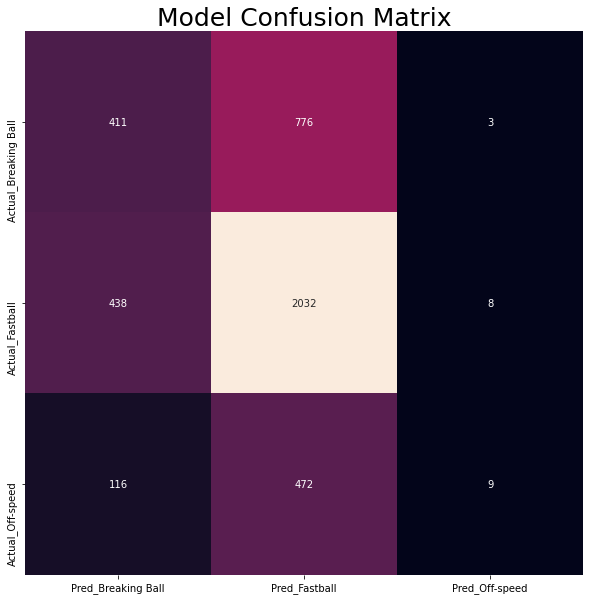

In [23]:
# Build a heatmap to visualize the confusion matrix

pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns

indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]

conf_mat = confusion_matrix(actual_pitch,pred_pitch)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            xticklabels=cols,
            yticklabels=indices,
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

This confusion matrix heatmap shows very clearly, this model only does "well" by predicting lots and lots of fastballs. This stems for the large degree of class imbalance in terms of fastballs. This will have the be addressed to build a better model.

***
Below is just some rough work in calculating precision/recall manually for different epochs when testing the model parameters.

In [131]:
# 50 epochs
# Precision: How accurate are our claims?

pfb = 2119/3473
pbb = 328/729
pof = 19/63

sum = pfb+pbb+pof
sum

1.3616540441678278

In [137]:
# 30 epochs
# Precision: How accurate are our claims?

pfb = 2184/3587
pbb = 287/631
pof = 16/47

sum = pfb+pbb+pof
sum

1.404124476465938

In [132]:
# 50 epochs
# Recall: Of all true class 1 data points, how many were we able to recall?
# RECALL is more important: want to be able to get as many of the correct pitches as possible

rfb = 2119/2478
rbb = 328/1190
ros = 19/597

sum = rfb + rbb + ros
sum

1.1625811486335442

In [138]:
# 30 epochs
# Recall: Of all true class 1 data points, how many were we able to recall?
# RECALL is more important: want to be able to get as many of the correct pitches as possible

rfb = 2184/2478
rbb = 287/1190
ros = 16/597

sum = rfb + rbb + ros
sum

1.1493330728083755

***

## AIM: Utilize downsampling to improve NN performance as well as test some other simpler models to compare performances.

***

The workflow below will be very similar to that of above since I am building effectively the same model, but with downsampling prior to the modeling. As such, the commenting will be less in depth.

In [27]:
# Do the imports again just in case
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import math

In [2]:
# Read in the original .csv as a new unaltered df
df = pd.read_csv('pitches_final_simplified.csv', index_col = 0)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.columns

Index(['game_date', 'release_speed', 'player_name', 'description', 'zone',
       'type', 'balls', 'strikes', 'plate_x', 'plate_z', 'on_3b', 'on_2b',
       'on_1b', 'outs_when_up', 'inning', 'sz_top', 'sz_bot', 'at_bat_number',
       'pitch_number', 'pitch_name', 'bat_score', 'fld_score', 'reg_season',
       'post_season', 'p_left', 'p_right', 'bat_left', 'bat_right',
       'prev_pitch'],
      dtype='object')

In [4]:
df.head()

,game_date,release_speed,player_name,description,zone,type,balls,strikes,plate_x,plate_z,...,pitch_name,bat_score,fld_score,reg_season,post_season,p_left,p_right,bat_left,bat_right,prev_pitch
0,2015-04-05,90.1,Adam Wainwright,ball,13,B,0,0,-1.585,1.720,...,Fastball,0,1,1,0,0,1,1,0,None
1,2015-04-05,88.1,Adam Wainwright,hit_into_play_no_out,5,X,1,0,0.008,2.602,...,Fastball,0,1,1,0,0,1,1,0,Fastball
2,2015-04-05,92.2,Adam Wainwright,foul,5,S,0,0,0.015,2.287,...,Fastball,0,1,1,0,0,1,0,1,None
3,2015-04-05,76.6,Adam Wainwright,blocked_ball,14,B,0,1,1.703,0.220,...,Breaking Ball,0,1,1,0,0,1,0,1,Fastball
4,2015-04-05,89.9,Adam Wainwright,hit_into_play,9,X,1,2,0.788,1.808,...,Fastball,0,1,1,0,0,1,0,1,Breaking Ball


In [5]:
# Subset
kershaw = df[df['player_name']=='Max Scherzer']

In [6]:
# Naturally expect a class imbalance for pitchers
kershaw['pitch_name'].value_counts()

Fastball         9910
Breaking Ball    4758
Off-speed        2389
Name: pitch_name, dtype: int64

Before downsampling, I decided to do some more stringent preprocessing in terms of getting rid of unwanted rows which contained invalid entries.

In [7]:
# Drop rows / intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Other'].index, inplace=True, errors = 'ignore')

# Also rows w/ drop the corresponding rows that contain them as a previous pitch
kershaw.drop(kershaw[kershaw['prev_pitch']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['prev_pitch']=='Pitch Out'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['prev_pitch']=='Other'].index, inplace=True, errors = 'ignore')

# Drop any rows w/ invalid values that may have slipped through
# balls > 3 or strikes > 2 means the at-bat is over
# outs > 2 means the inning is over
kershaw.drop(kershaw[kershaw['balls'] > 3].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['strikes'] > 2].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['outs_when_up']> 2].index, inplace=True, errors = 'ignore')

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
# Unable to classify/do regression with classes with only 1 instance
# so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
for i in range(len(kershaw['pitch_name'].value_counts())):
    if kershaw['pitch_name'].value_counts()[i] == 1:
        drop = kershaw['pitch_name'].value_counts().index[i]
        kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
        kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

# Drop some unnecessary cols
kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

# Don't need pitcher handedness in this, the variance of the columns will be 0
kershaw.drop(['p_left', 'p_right'], axis = 1, inplace = True)

# Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
kershaw.drop(['release_speed'], axis = 1, inplace = True)

# Drop other non pre-pitch predicative stuff
kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)
kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)


# Make dummies
balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')
strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')
prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

# I forgot to one-hot-encode outs above, I did so here
outs = pd.get_dummies(kershaw['outs_when_up'], prefix = 'o_')

# Combine together
X = pd.concat([kershaw, balls, strikes, outs, prev], axis = 1)

# Drop the original columns
X.drop(['balls', 'strikes', 'outs_when_up', 'prev_pitch'], axis = 1, inplace = True)

# One-hot-encode innings
X['early'] = np.where(X['inning'] <= 3, 1, 0)
X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)
# Drop original
X.drop(['inning'], axis = 1, inplace = True)

# Drop other non pre-pitch predicative stuff
X.drop(['pitch_number'], axis = 1, inplace = True)
X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)
X.drop(['zone'], axis = 1, inplace = True)

In [9]:
# Set X and y
X1 = X.drop(['pitch_name'], axis = 1)
y = X['pitch_name']

***
So here I was deciding whether I wanted to downsample BEFORE or AFTER doing the train/test split. I decided on AFTER.

I wanted the model is be just fitted on downsampled data but I still wanted to to be tested on imbalanced data. I figured that downsampling the test data would contribute nothing to the model fitting process and it would be loss of valuable test data.

In [10]:
from sklearn.model_selection import train_test_split

# Split with stratification given the class imbalance is still present
X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25, random_state=123)
y_test_copy = y_test.copy()

In [11]:
# In order to downsample (ie. randomly sample), the X_train and y_train need to be re-joined
# This is to ensure that the labels don't get attached to the wrong rows
train = pd.concat([X_train, y_train], axis =1)

In [12]:
# Recall the classes and value counts
kershaw['pitch_name'].value_counts()

Fastball         9910
Breaking Ball    4758
Off-speed        2389
Name: pitch_name, dtype: int64

Viewing some other player distributions as well:

In [13]:
df[df['player_name'] == 'Zack Greinke']['pitch_name'].value_counts()

Fastball         7852
Breaking Ball    4906
Off-speed        3026
Junk              136
Other              12
Name: pitch_name, dtype: int64

In [14]:
df[df['player_name'] == 'Stephen Strasburg']['pitch_name'].value_counts()

Fastball         7206
Breaking Ball    3793
Off-speed        2351
Other               4
Name: pitch_name, dtype: int64

In [15]:
df[df['player_name'] == 'Gerrit Cole']['pitch_name'].value_counts()

Fastball         9521
Breaking Ball    5314
Off-speed        1010
Other              18
Name: pitch_name, dtype: int64

In [16]:
df[df['player_name'] == 'Clayton Kershaw']['pitch_name'].value_counts()

Breaking Ball    7388
Fastball         6965
Off-speed          68
Other               5
Name: pitch_name, dtype: int64

In [17]:
df[df['player_name'] == 'Hyun-Jin Ryu']['pitch_name'].value_counts()

Fastball         3831
Off-speed        1599
Breaking Ball    1082
Other               4
Junk                1
Name: pitch_name, dtype: int64

***

For this pitcher, the majority class (Fastball) dominates both minority classes. The two minority classes are relatively similar in terms of counts compared to that of the majority class. While this distribution is going to vary player to player it is going be extremely impractical for me to manually adjust them for a list of pitchers which is what I aim to do in order to build individual models for various players.

Looking at the various players and their pitch type distributions above, it appears that the 3rd minority class will either be roughly at the same frequency of the second, or it will be much lower. 

Based on this, I will not be upsampling this class. If it is at roughly the same frequency, then there is not a pressing need to upsample. Alternatively, if it is much lower then upsampling will heavily bias the model towards that particular set of repeating scenarios. 

In practice, these pitches at very low frequencies are **designed to be unpredictable**. They are a relatively rare pitch type that the pitcher will pull out of their toolkit intentionally to throw the batter off balance. Therefore, at this stage, fitting and training a model to correctly predict these pitches will likely do more harm than good as it will be overfit to these edge cases.

Based on the above rationale, I will focus on downsampling just the majority class down to the same level as the most frequent minority class. I recognize this is not a perfect way to do it, but it is scalable as opposed to tailoring the down/upsampling to an individual pitcher.

When refining the model in the future, I will look into better ways to go about this and retrain the models.

In [18]:
# Get the majority class
df_major =  train[train['pitch_name']==train['pitch_name'].value_counts().index[0]]
# Rest of the classes
df_rest = train[train['pitch_name']!=train['pitch_name'].value_counts().index[0]]

# Resample the majority class until the number of counts reachs that of the most frequent minority class
df_down = resample(df_major, 
                      replace=True, 
                      n_samples = train['pitch_name'].value_counts().values[1], 
                      random_state=123)

# Combine them
df_downsampled = pd.concat([df_down, df_rest])

In [48]:
# Make sure everything went according to plan
df_downsampled.columns

Index(['on_3b', 'on_2b', 'on_1b', 'bat_score', 'fld_score', 'reg_season',
       'post_season', 'bat_left', 'bat_right', 'b__0', 'b__1', 'b__2', 'b__3',
       's__0', 's__1', 's__2', 'o__0', 'o__1', 'o__2', 'prev__Breaking Ball',
       'prev__Fastball', 'prev__None', 'prev__Off-speed', 'early', 'mid',
       'late', 'pitch_name'],
      dtype='object')

In [19]:
# Recall that X_train and y_train were combined for the downsampling process
# Drop the target column from the X_train
# NOTE: this is NOT done inplace
X_train = df_downsampled.drop(['pitch_name'], axis = 1)

In [20]:
# Make sure it worked
X_train.columns

Index(['on_3b', 'on_2b', 'on_1b', 'bat_score', 'fld_score', 'reg_season',
       'post_season', 'bat_left', 'bat_right', 'b__0', 'b__1', 'b__2', 'b__3',
       's__0', 's__1', 's__2', 'o__0', 'o__1', 'o__2', 'prev__Breaking Ball',
       'prev__Fastball', 'prev__None', 'prev__Off-speed', 'early', 'mid',
       'late'],
      dtype='object')

In [21]:
# Now set y_train again
y_train = df_downsampled['pitch_name']
# Verify downsampling
y_train.value_counts()

Fastball         3568
Breaking Ball    3568
Off-speed        1792
Name: pitch_name, dtype: int64

In [22]:
# Make sure y_test hasn't been altered
y_test.value_counts()

Fastball         2478
Breaking Ball    1190
Off-speed         597
Name: pitch_name, dtype: int64

In [23]:
# Convert output to an array
pitch = pd.get_dummies(y_train.copy())
y_train = pitch.values

In [24]:
pitch = pd.get_dummies(y_test.copy())
y_test = pitch.values

In [25]:
# Verify
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8928, 26)
(8928, 3)
(4265, 26)
(4265, 3)


In [57]:
# Best performing one so far
opt = tf.keras.optimizers.Adam(lr=0.0001)

***

## Optimize epochs

Here, I'm taking a more methodological approach to setting the number of epoch as opposed to before.

In [527]:
# See how the # of epochs affect accuracy
# Empty lists to append test loss/acc to
testacc = []
testloss = []

# Loop through 1-75 epochs
eps = np.arange(1, 76)
for i in eps:
    # Same model structure as above
    # Reset model every time or it will continue to run further epochs on same model
    input_layer = Input(shape = (X_train.shape[1], ))
    dense_layer_1 = Dense(512, activation='relu')(input_layer)
    drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
    dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
    drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
    dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
    drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
    dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
    # Output shape equals to number of classes (columns) in y
    output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    
    # Fit the model with varying # of epochs based on the loop
    history = model.fit(X_train, y_train, batch_size=25, epochs=i, verbose=0, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    # Append the test loss and test scores of each run to the list
    testloss.append(score[0])
    testacc.append(score[1])

121/121 [==============================] - 0s 1ms/step - loss: 1.0481 - acc: 0.4420


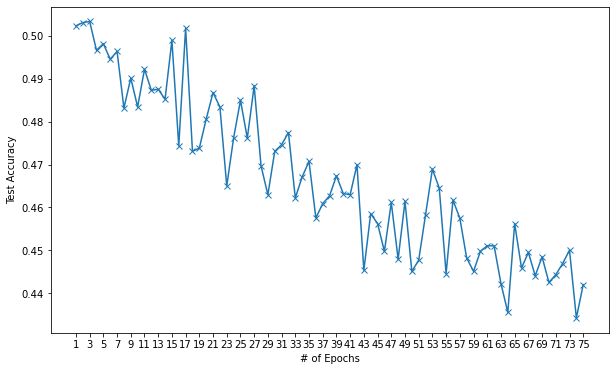

In [528]:
# Acc seems to peak at 17 epochs
plt.figure(figsize = (10,6))
plt.plot(eps, testacc, marker = 'x')
plt.xticks(np.arange(1, 76, 2))
plt.xlabel('# of Epochs')
plt.ylabel('Test Accuracy')
plt.show()

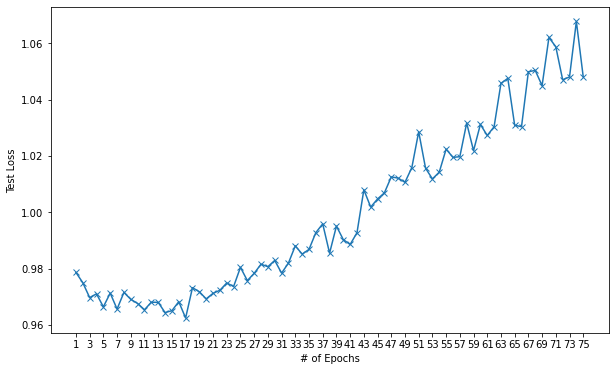

In [529]:
# Loss also bottoms at 17 epochs
plt.figure(figsize = (10,6))
plt.plot(eps, testloss, marker = 'x')
plt.xticks(np.arange(1, 76, 2))
plt.xlabel('# of Epochs')
plt.ylabel('Test Loss')
plt.show()

While it is worthwhile to note that every player will have slightly different plots in terms of test acc/loss vs number of epochs, I expect the overall trend to be the same.

Since test accuracy and test loss both reach their ideal points at 17 epochs, 17 epochs is a good candidate to move forward with.

While it is possible for me to try and run this loop while looping through every player I have on my list, it will take some time. Instead, I ran the model at a fixed 17 epochs for all my players (vs the 30 epochs I ran prior) and can attest that 17 epochs resulted in better performance across the board. 

This leads me to believe that 17 epochs, while not the absolute optimal number for everybody, is at least close to the optimal number of epochs. To keep the models consistent across players so that in the end I can evaluate which players are more "unpredictable", I will be using 17 epochs for everybody.

***

In [58]:
# Run model now with 17 epochs

# Make sure to reset model before running each time
input_layer = Input(shape = (X_train.shape[1], ))
dense_layer_1 = Dense(512, activation='relu')(input_layer)
drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
# Output shape equals to number of classes (columns) in y
output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=25, epochs=17, verbose=1, validation_split=0.2)

Epoch 1/17
286/286 [==============================] - 1s 5ms/step - loss: 1.0155 - acc: 0.4938 - val_loss: 1.2550 - val_acc: 0.0034
Epoch 2/17
286/286 [==============================] - 1s 4ms/step - loss: 0.9683 - acc: 0.5084 - val_loss: 1.1823 - val_acc: 0.3152
Epoch 3/17
286/286 [==============================] - 1s 4ms/step - loss: 0.9512 - acc: 0.5130 - val_loss: 1.1841 - val_acc: 0.3830
Epoch 4/17
286/286 [==============================] - 1s 4ms/step - loss: 0.9415 - acc: 0.5220 - val_loss: 1.1773 - val_acc: 0.3746
Epoch 5/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9365 - acc: 0.5228 - val_loss: 1.1439 - val_acc: 0.4216
Epoch 6/17
286/286 [==============================] - 1s 4ms/step - loss: 0.9300 - acc: 0.5311 - val_loss: 1.1635 - val_acc: 0.3735
Epoch 7/17
286/286 [==============================] - 1s 4ms/step - loss: 0.9258 - acc: 0.5372 - val_loss: 1.1413 - val_acc: 0.3701
Epoch 8/17
286/286 [==============================] - 1s 4ms/step - loss: 0.

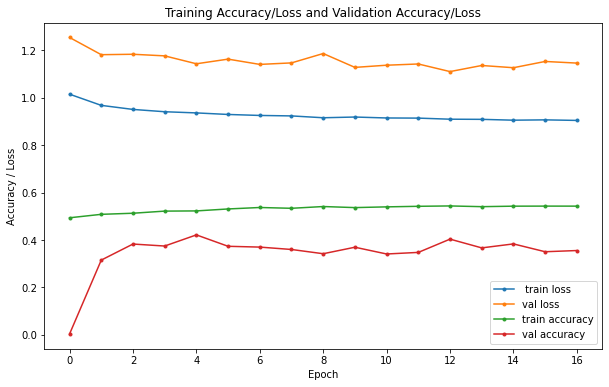

In [59]:
# Visualize train/test loss over epochs to check for overfitting
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.show()

In [60]:
# Get test score
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

134/134 [==============================] - 0s 2ms/step - loss: 0.8806 - acc: 0.5639
Test Loss: 0.8805938959121704
Test Accuracy: 0.563892126083374


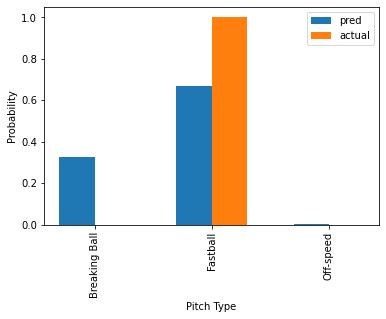

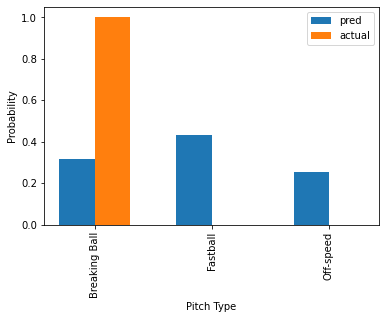

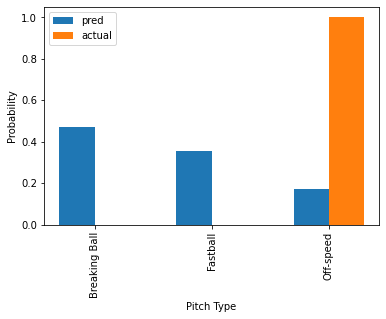

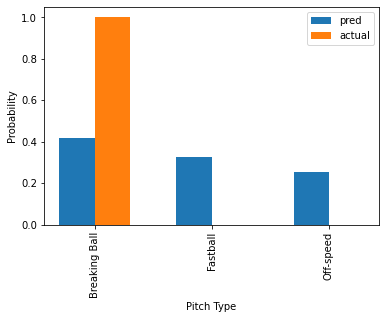

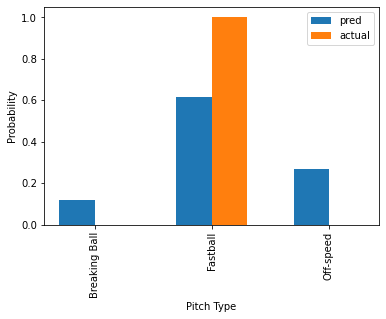

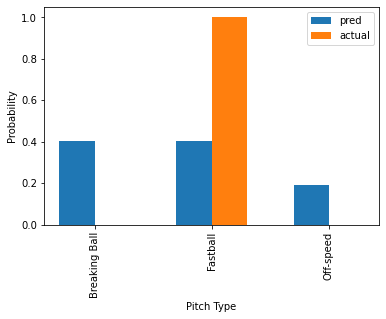

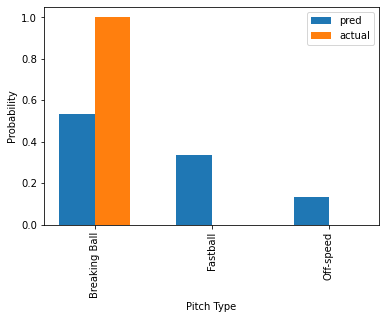

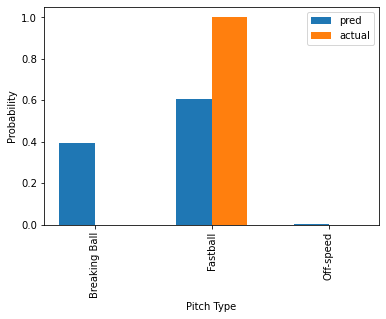

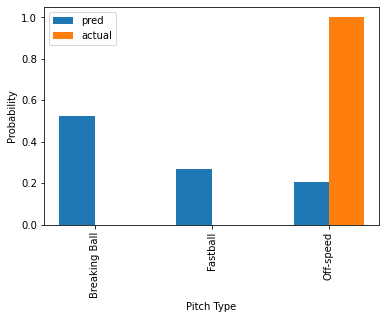

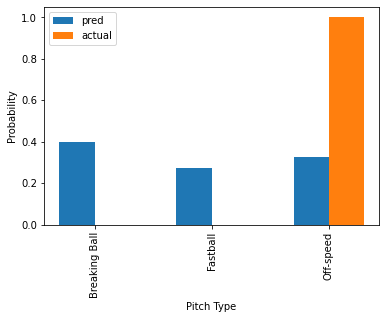

In [68]:
# Just for fun, get a look at some predictions vs actual
predictions = model.predict(X_test)

xnames = pitch.columns

indices = np.arange(len(pitch.columns))
width = 0.3

for i in np.arange(10):
    plt.bar(indices-width/2, predictions[i], width, label = 'pred')
    plt.bar(indices + width/2, y_test[i], width, label = 'actual')
    plt.ylabel('Probability')
    plt.xlabel('Pitch Type')
    plt.legend()
    plt.xticks(indices, xnames, rotation=90)
    plt.show()

The test accuracy went down compared to before at 56.4% vs 57.5% prior to downsampling. This was almost to be expected as we are no longer largely predicting members of the dominant class and so the accuracy will not be artificially boosted by high recall in the majority class.

In [61]:
# Get confusion matrix
predictions = model.predict(X_test)

pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns


# Transform confusion matrix to df
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,616,566,8,1190
Actual_Fastball,678,1773,27,2478
Actual_Off-speed,168,413,16,597
Sum of Predictions,1462,2752,51,4265


In [62]:
from sklearn.metrics import f1_score

print('Macro: ', f1_score(actual_pitch, pred_pitch, average = 'macro'))
print('Weighted: ', f1_score(actual_pitch, pred_pitch, average = 'weighted'))

Macro:  0.3973164137050214
Weighted:  0.5304605914654802


A look at the confusion matrix and the macro F1 score confirms that by sacrificing recall in the dominant class, the performance for the minority classes has been improved. 

The macro F1 score is not 39.7 as opposed to 37.2 prior to downsampling.

Looking at the distribution of predicted classes, there is a 2:1 split between the majority and 2nd class, resembling that of the actual distribution. 

However, a problem lies with the least frequent class, in this case `Off-speed`. There was **597** off-speed pitches within the test set, however the model only predicted off-speed pitches **51** times. 

In [52]:
# RECALL the training class splits
# Verify downsampling
y_train.value_counts()

Fastball         3568
Breaking Ball    3568
Off-speed        1792
Name: pitch_name, dtype: int64

This is a glaring difference and honestly surprising, given that the distribution of classes in the training set was 2:2:1, so the off-speed class still had a fair amount of representation.

Anecdotally, this may be due to the fact that `off-speed` pitches serve predominantly to throw batters who are expecting fastballs off balance from the change of velocity. Off-speed pitches are pitches designed to resemble a fastball visually but are slower, throwing off the timing of batters. Therefore, they are often throw in "fastball situations" for the purpose of tricking the batter.

Looking at the confusion matrix, of the 597 actual off-speed pitches, 413 were predicted as fastball, while only 168 were predicted as breaking balls, the other class which after downsampling, had the same frequency in the training set as fastballs. It appears that this is due to intentional pitcher confusion, of both batter and model, for the reasons stated above.

Perhaps adding various other features to the dataset such as pitch number of the at bat or previous pitch result will help differentiate fastball and off-speed situations a bit more but given the current features, it is difficult to parse these two classes (for this player anyways).

In [63]:
# Get classification report
from sklearn.metrics import classification_report

# Convert the array of integers into the pitch names using nested np.where functions
# Added further clauses since certain pitchers can have 2, 3 or 4 different classes of pitches
# For 2 pitch pitchers:
if max(actual_pitch) == 1:
    actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                            np.where(actual_pitch == 1, xnames.values[1], actual_pitch))

    pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                            np.where(pred_pitch == 1, xnames.values[1], pred_pitch))
elif max(actual_pitch) == 2:
    # For 3 pitch pitchers:
    actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                            np.where(actual_pitch == 1, xnames.values[1], 
                                     np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

    pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                            np.where(pred_pitch == 1, xnames.values[1], 
                                     np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))
elif max(actual_pitch) == 3:
    # For 4 pitch pitchers:    
    actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                            np.where(actual_pitch == 1, xnames.values[1], 
                                     np.where(actual_pitch == 2, xnames.values[2], 
                                              np.where(actual_pitch == 3, xnames.values[3], actual_pitch))))

    pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                            np.where(pred_pitch == 1, xnames.values[1], 
                                     np.where(pred_pitch == 2, xnames.values[2], 
                                              np.where(pred_pitch == 3, xnames.values[3], pred_pitch))))


report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.52      0.46      1190
     Fastball       0.64      0.72      0.68      2478
    Off-speed       0.31      0.03      0.05       597

     accuracy                           0.56      4265
    macro avg       0.46      0.42      0.40      4265
 weighted avg       0.54      0.56      0.53      4265



Aside from off-speed pitches, this model performs relatively well for 2/3 classes and is an improve over the first one which did not incorporate downsampling.

These results are satisfactory enough for me to move forward with at this point.

In [475]:
# Save model
#model.save('saved_model/kershaw') 

INFO:tensorflow:Assets written to: saved_model/kershaw\assets


***

With a model created, I now wanted an avenue for a custom input to be able to be evaluated by the model. I figured since the NN takes in test data in dataframe format, I will need to construct a template dataframe mirroring the X_test/X_train one to be fed in to the model. The template will also need to be able to be overwritted based on inputs.

In [354]:
# Create a new row that starts with all zeros and then fill it up later according to inputs
new_row = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0]], columns = X_train.columns)
# Save for later use when getting user inputs through Flask
new_row.to_csv('for_inputs.csv')

In [355]:
# Test to see if it can be written over
pd.options.display.max_columns = None
test = pd.read_csv('for_inputs.csv', index_col = 0)
test['s__0'] = 1
test

,on_3b,on_2b,on_1b,bat_score,fld_score,reg_season,post_season,bat_left,bat_right,b__0,b__1,b__2,b__3,s__0,s__1,s__2,o__0,o__1,o__2,prev__Breaking Ball,prev__Fastball,prev__None,prev__Off-speed,early,mid,late
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


***
## Creating a baseline:

In [ ]:
### Upon further thought, this is not the best baseline indicator!
'''
fb = y_test.copy()

# Baseline accuracy if guess was ALL 4 seam fastball

# Equals a copy to not modify the original just in case
fb = y_test.copy()

# Make all elements an array that corresponds to 4S-FB
for i in range(len(fb)):
    fb[i] = np.array([0,1,0,0,0,0])

match = 0
for i in range(len(fb)):
    # Add 1 to match if the arrays correspond to 4S-FB
    if np.all(fb[i] == y_test[i]):
        match = match+1
        
# Accuracy score caluclated by matches/total
acc = match/len(fb)
acc
'''

RECALL:

In [29]:
print(y_train.shape)

(8928, 3)


In [22]:
# Make sure y_test hasn't been altered
y_test.value_counts()

Fastball         2478
Breaking Ball    1190
Off-speed         597
Name: pitch_name, dtype: int64

In [39]:
# Get what the actual pitch class was in the test set
actual = np.argmax(y_test, axis = 1)
actual

array([1, 0, 2, ..., 1, 1, 0], dtype=int64)

In [40]:
# Creating a baseline using random weighted sampling
np.random.seed(123)

# Choices are 0, 1, or 2
possiblerolls = np.arange(0, 3)

# Total number of test samples
sum = y_test.shape[0]

# Set the weighted probability of each class to be equal to their % representation in the test set
probs = [2478/sum, 1190/sum, 597/sum]

# Roll same number of times as y_test, set probability of each class to be their % frequency in the set
biased_rolls = np.random.choice(possiblerolls, replace = True, size = (y_test.shape[0]), p = probs)

# Set number of correct to be 0 to start
correct = 0

# Iterate through array of predictions for actual and the random rolls
# If the randomly chosen class is equal to that of the actual at the position, set add a point to number of correct
for i in range(len(actual)):
    if actual[i] == biased_rolls[i]:
        correct = correct + 1
        
# Get the percent correct by this random predictor       
rand_acc = correct/sum
print(rand_acc)

0.3493552168815944


By using a weighted random model, the baseline accuracy was **35%**. Therefore, the NN accuracy was **20% higher**, indicating that it is doing a fairly decent job given the problem scope!

---

## Other models

#### Here I'll be trying a couple simpler models to compare to be NN. Perhaps they may even perform better than the NN. But as mentioned earlier, I gravitated towards NN's because I wanted to get more practice in using/building them.

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [71]:
# Need to use different types of y values for DTree (y can't be an array like for TF/Keras)
y_pitch = df_downsampled['pitch_name']

In [72]:
# Instantiate decision tree w/o any parameters for now, set random state for consistency
tree = DecisionTreeClassifier(random_state=123)

# Set range of values
depth = np.arange(1, 21)
leafs = np.arange(1,10)

# Create dictionary of parameters
params = {'max_depth':depth, 'min_samples_leaf':leafs}

# Instatiate grid search using my tree model and my parameters, and 5 fold cross val
# Use ALL cores
grid = GridSearchCV(tree, params, cv=5, n_jobs = -1, verbose = 1)

# Fit grid to my training data
fittedgrid = grid.fit(X_train, y_pitch)

# Get best one
fittedgrid.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   19.4s finished


DecisionTreeClassifier(max_depth=1, random_state=123)

In [73]:
tree = DecisionTreeClassifier(max_depth = 1, random_state=123).fit(X_train, y_pitch)
tree.score(X_test, y_test_copy)

0.5453692848769051

Practically speaking a decision tree with a max depth of 1 is not very useful for predicting a pitch with the overall goal of making it something that a batter can use. Even with a comparable accuracy of 54.5%, I have my doubts for the usefulness of this model.

If a batter only considers one question before deciding a pitch, it will generally not end well. In addition, there are 3 classes and if there is only a depth of 1, then only 2 classes can be predicted.

So I decided to try a more reasonable and practical depth of 3. As it turned out, a depth of 3 produced the **exact same accuracy** as a depth of 1, so I went with 3.

In [74]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=123).fit(X_train, y_pitch)
tree.score(X_test, y_test_copy)

0.5453692848769051

In [75]:
# Get classification report again with np.where clauses to sub in real class names for 0, 1, 2

y_pred = tree.predict(X_test)

y_pred_array = pd.get_dummies(y_pred).values

pred_pitch = np.argmax(y_pred_array,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)


actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.71      0.53      1190
     Fastball       0.66      0.60      0.63      2478
    Off-speed       0.00      0.00      0.00       597

     accuracy                           0.55      4265
    macro avg       0.36      0.44      0.38      4265
 weighted avg       0.50      0.55      0.51      4265



C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
# Get confusion matrix
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,843,347,0,1190
Actual_Fastball,995,1483,0,2478
Actual_Off-speed,163,434,0,597
Sum of Predictions,2001,2264,0,4265


Almost to be expected, since the tree with max depth of 3 had the exact same accuracy as the tree with max depth of 1, the predictions would need to also be the same. Since a tree of depth 1 can only predict between 2 classes, it is no suprise that there were only 2 classes predicted, `Breaking Ball` and `Fastball`. No `Off-speed` pitches were predicted.

In addition the predicted breaking balls:fastball ratio was 1:1, not reflecting the 2:1 ratio in the actual classes. 

Therefore, decision trees are not a good model for my project.

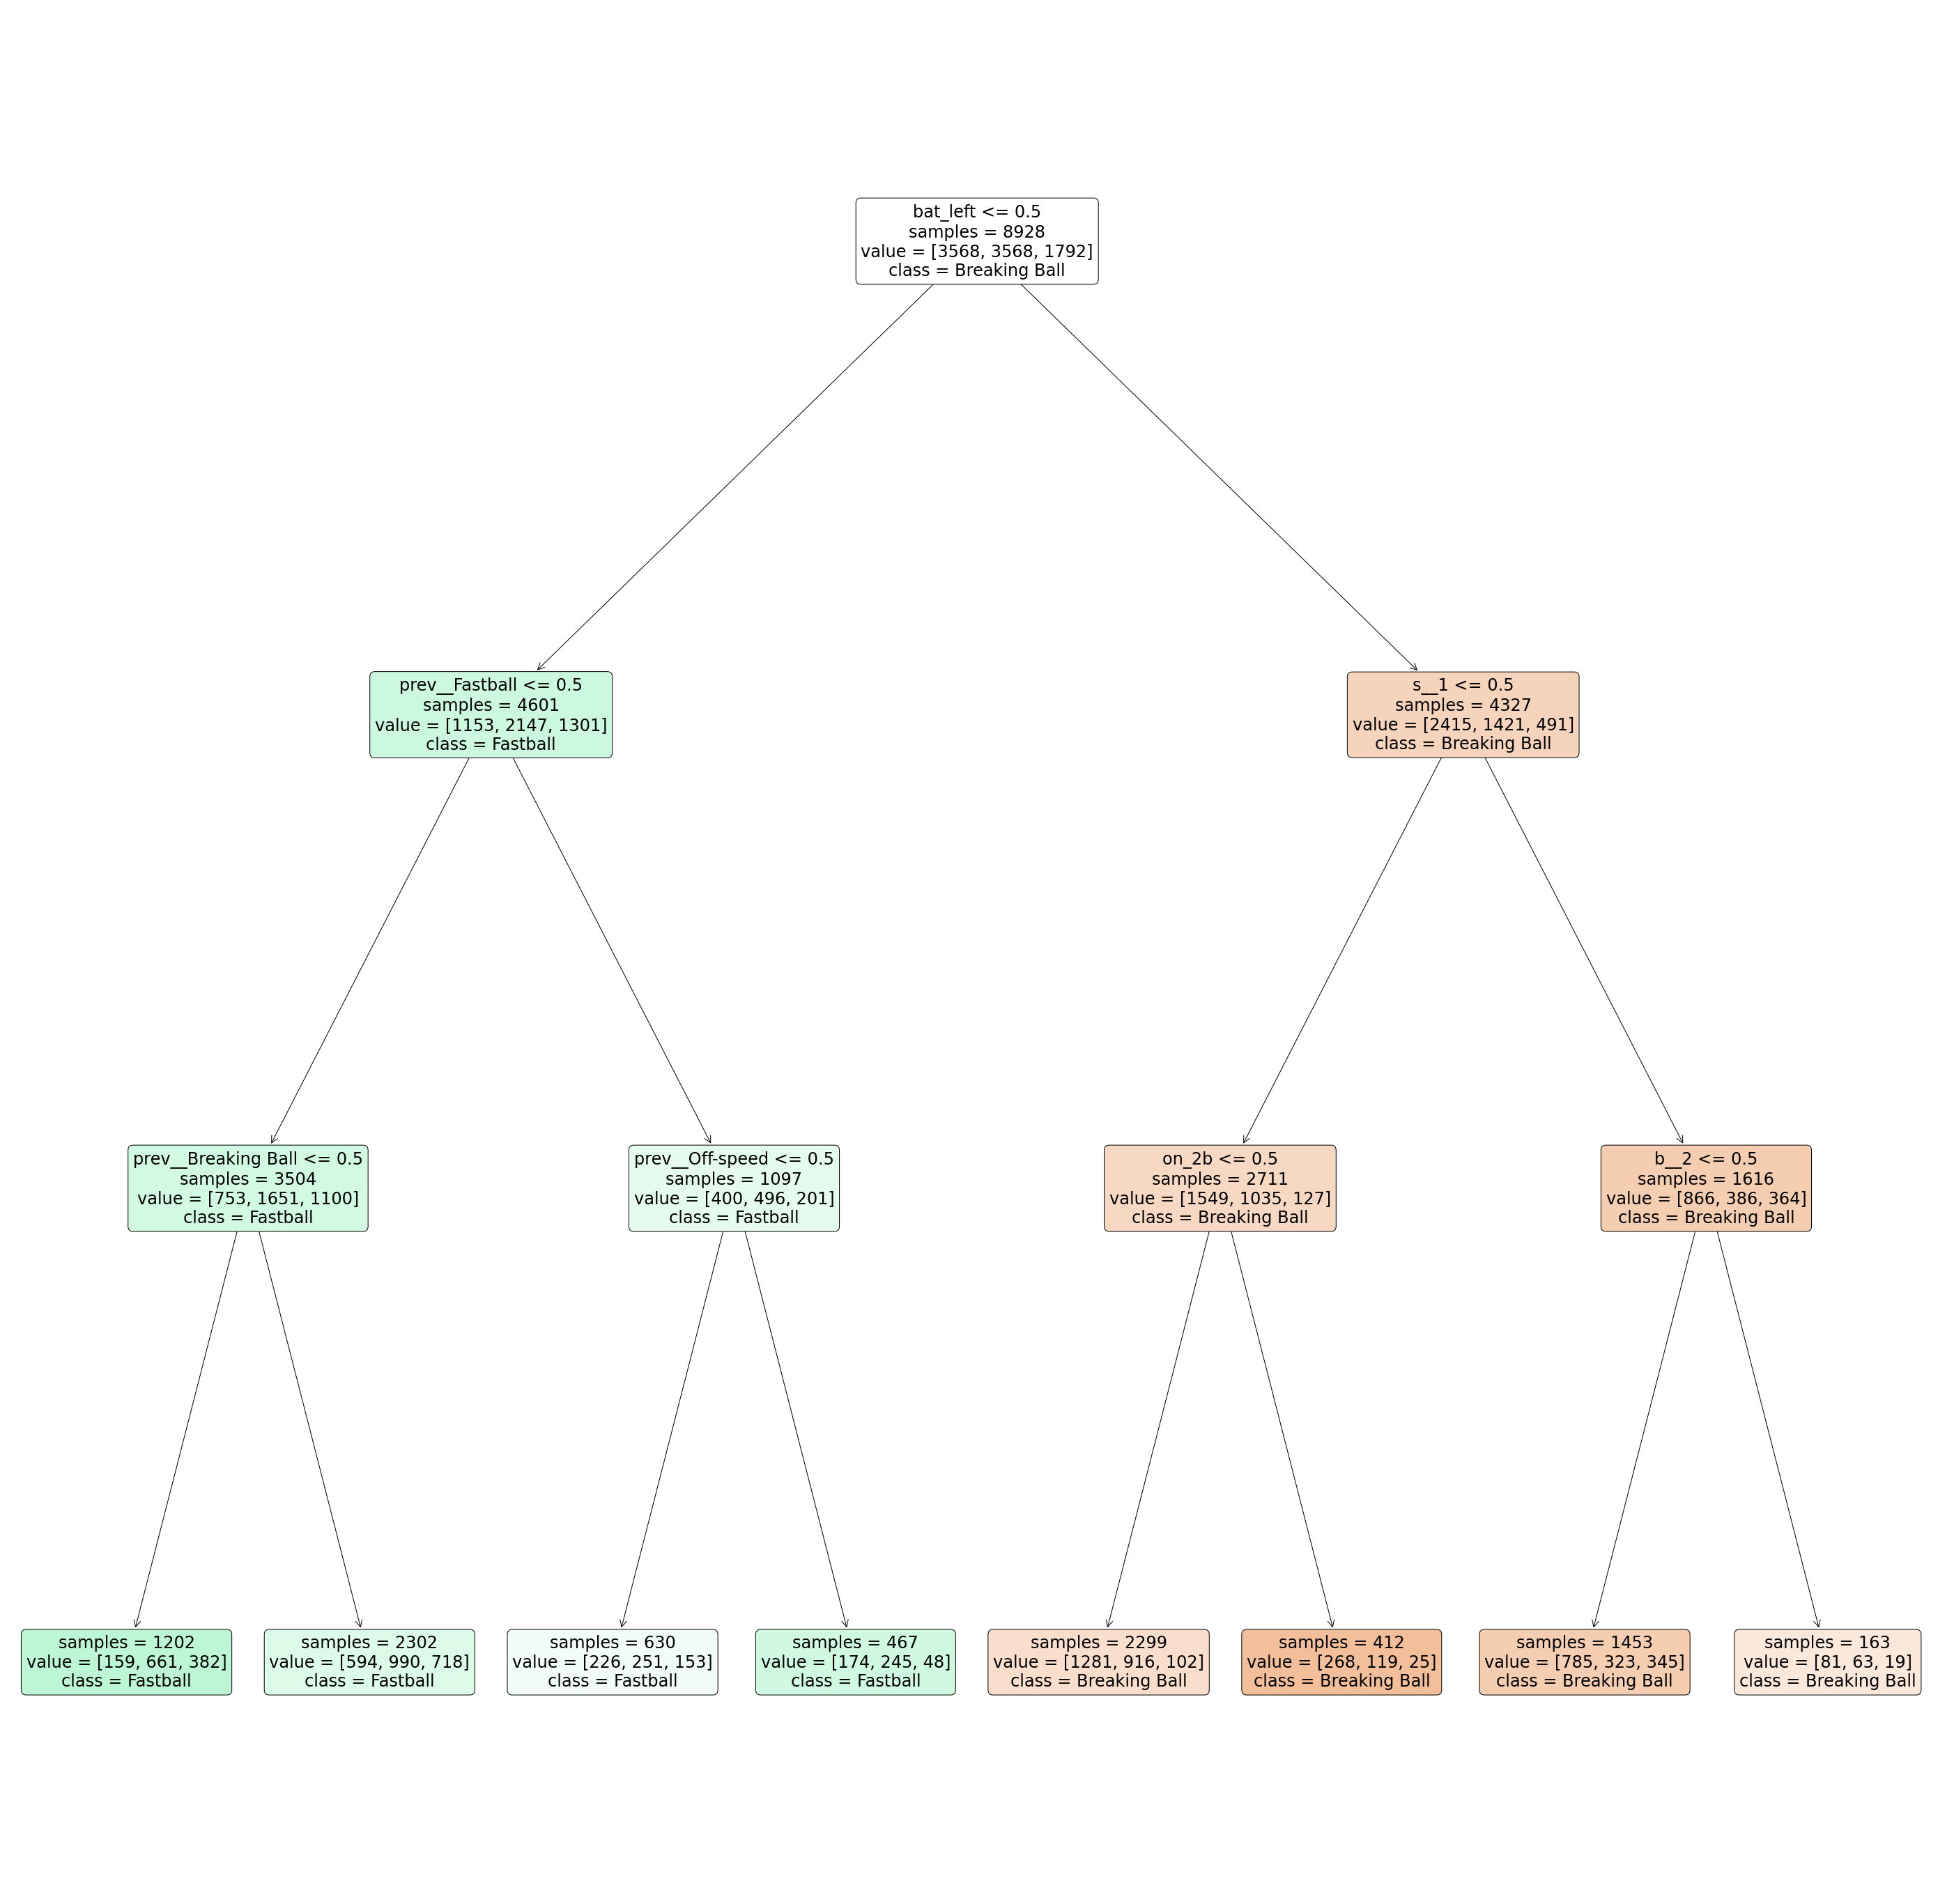

In [77]:
# Plot out the tree for fun to see what the nodes are

from sklearn.tree import plot_tree
plt.figure(figsize = (50, 50))
plot_tree(tree, 
          feature_names=X.columns, 
          class_names=xnames.values,
          rounded=True,
          impurity=False,
          filled=True)
plt.show()

***

In [79]:
from sklearn.linear_model import LogisticRegression

In [80]:
# Set up grid search

pens = ['l1', 'l2']
c_vals = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
logreg = LogisticRegression(solver = 'lbfgs')

params = {'C':c_vals, 'penalty':pens}

# Instatiate grid search using my logit model and my parameters, and 5 fold cross val
# Use ALL cores
grid = GridSearchCV(logreg, params, cv=5, n_jobs = -1, verbose = 1)

# Fit grid to my training data
fittedgrid = grid.fit(X_train, y_pitch)

# Get best one
fittedgrid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.2s finished


LogisticRegression(C=0.001)

In [81]:
# Use best params
logit = LogisticRegression(C = 0.001, solver = 'lbfgs').fit(X_train, y_pitch)
logit.score(X_test, y_test_copy)

0.5441969519343494

The accuracy for the logistic regression is again comparable to that of the NN, albeit slightly lower (54.4% vs 56.4%). But the more important factor that is clear by now is the F1 score and the confusion matrix.

In [82]:
# Get classification report
y_pred = logit.predict(X_test)

y_pred_array = pd.get_dummies(y_pred).values

pred_pitch = np.argmax(y_pred_array,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)


actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))
report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.71      0.53      1190
     Fastball       0.66      0.59      0.62      2478
    Off-speed       0.31      0.01      0.03       597

     accuracy                           0.54      4265
    macro avg       0.46      0.44      0.39      4265
 weighted avg       0.54      0.54      0.51      4265



In [83]:
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,840,346,4,1190
Actual_Fastball,991,1473,14,2478
Actual_Off-speed,163,426,8,597
Sum of Predictions,1994,2245,26,4265


The macro F1 score for the logistic regression is effectively the same as the NN (0.39 vs 0.40)!

However, looking at the confusion matrix and a breakdown of the F1 scores for each class, the logistic regression score is largely boosted up by its increased number of predictions for the `Breaking Ball` class. Both models have poor and negligible scores for `Off-speed` but given the much higher number of predictions for `Breaking Ball` in the logistic regression, it boosted the recall score of the class and therefore, its F1 score.

Looking at the confusion matrix confirms this. Logistic regression nearly predicts a 1:1 ratio of breaking ball:fastballs, while the actual ratio is 1:2.

Therefore, logistic regressions do not capture the underlying pattern of the data and is not an effective model for this project.

***

## Summary

The NN generally performs slightly better or on par compared to the logistic regression and decision trees in terms of accuracy. However, it consistently performs better when looking at the weighted F1 score across the classes and in capturing the underlying data trends.

Looking at the confusion matrices, the bulk of the logistic regression accuracy and F1 score can be attributed to its high number of predictions for the 2 more abundant classes.

The decision tree is unable to predict the least abundant class at all and also does not capture the underlying class distribution.

In general, the NN may perform only slightly better in terms of overall accuracy, but its predictions reflect the underlying uneven distribution of pitche classes in the test set and is therefore the more practical model.

***

## Creating NNs for All Pitchers

Here I am automating the process of fitting NN's and saving them to all the pitchers in my list. The code is the same as above but complied into a singular cell.

In [727]:
# List of players to go through for now
player_list = ['Clayton Kershaw', 'Justin Verlander', 'Max Scherzer', 'Stephen Strasburg', 'Gerrit Cole',
              'Jacob deGrom', 'Zack Greinke', 'Madison Bumgarner', 'Marcus Stroman', 'Chris Sale', 'Hyun-Jin Ryu']

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


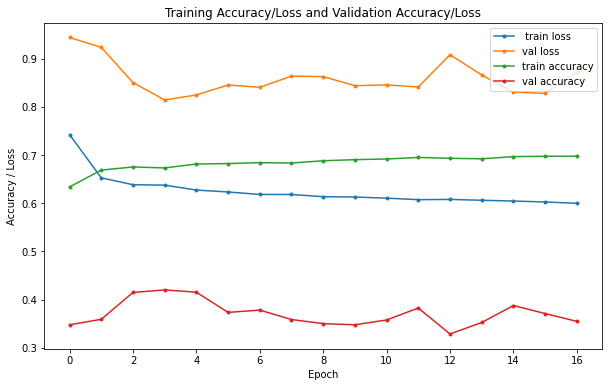

113/113 [==============================] - 0s 1ms/step - loss: 0.6746 - acc: 0.6187
Test Loss: 0.6746216416358948
Test Accuracy: 0.618691086769104


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.58      0.89      0.70      1847
     Fastball       0.74      0.34      0.47      1742
    Off-speed       0.00      0.00      0.00        17

     accuracy                           0.62      3606
    macro avg       0.44      0.41      0.39      3606
 weighted avg       0.66      0.62      0.59      3606

INFO:tensorflow:Assets written to: saved_model/kershaw\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


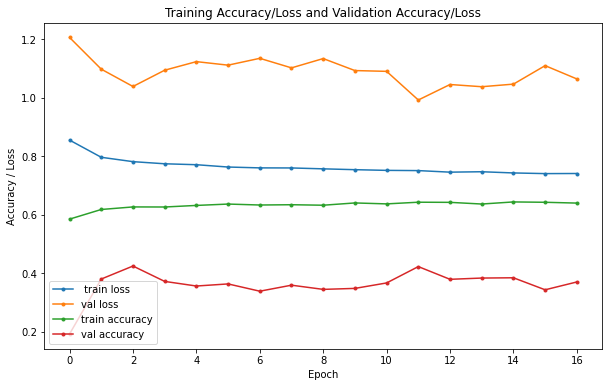

137/137 [==============================] - 0s 1ms/step - loss: 0.7599 - acc: 0.6318
Test Loss: 0.759920060634613
Test Accuracy: 0.6318327784538269


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.58      0.42      0.49      1634
     Fastball       0.65      0.83      0.73      2500
    Off-speed       0.00      0.00      0.00       220

     accuracy                           0.63      4354
    macro avg       0.41      0.42      0.40      4354
 weighted avg       0.59      0.63      0.60      4354

INFO:tensorflow:Assets written to: saved_model/verlander\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


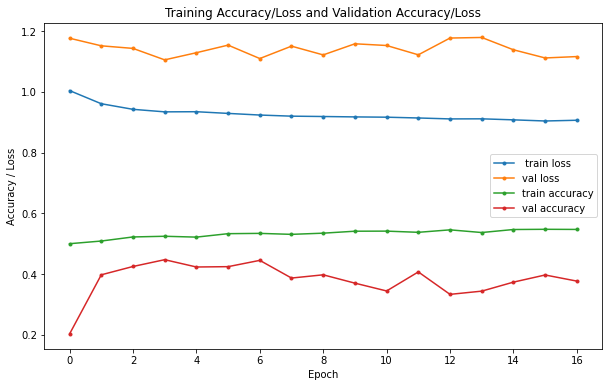

134/134 [==============================] - 0s 1ms/step - loss: 0.8884 - acc: 0.5660
Test Loss: 0.888405978679657
Test Accuracy: 0.566002368927002
               precision    recall  f1-score   support

Breaking Ball       0.43      0.55      0.49      1190
     Fastball       0.65      0.70      0.67      2478
    Off-speed       0.30      0.04      0.07       597

     accuracy                           0.57      4265
    macro avg       0.46      0.43      0.41      4265
 weighted avg       0.54      0.57      0.54      4265

INFO:tensorflow:Assets written to: saved_model/scherzer\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


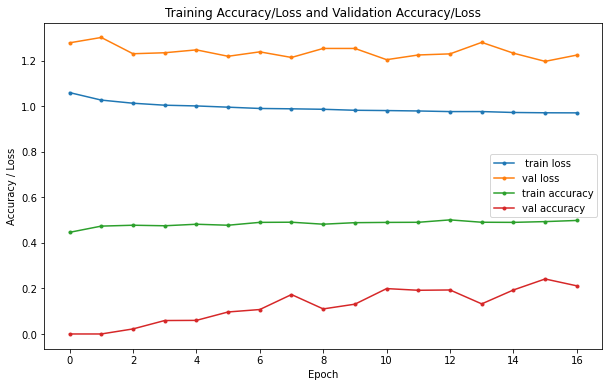

105/105 [==============================] - 0s 1ms/step - loss: 0.9600 - acc: 0.5093
Test Loss: 0.959986686706543
Test Accuracy: 0.5092869997024536
               precision    recall  f1-score   support

Breaking Ball       0.34      0.23      0.28       948
     Fastball       0.57      0.77      0.66      1802
    Off-speed       0.36      0.15      0.21       588

     accuracy                           0.51      3338
    macro avg       0.42      0.39      0.38      3338
 weighted avg       0.47      0.51      0.47      3338

INFO:tensorflow:Assets written to: saved_model/strasburg\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


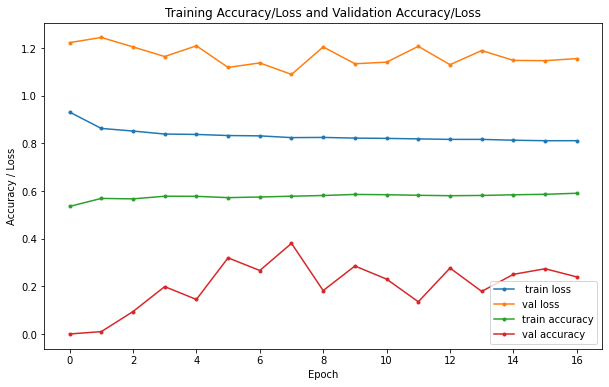

124/124 [==============================] - 0s 2ms/step - loss: 0.8095 - acc: 0.5966
Test Loss: 0.809485673904419
Test Accuracy: 0.5965664982795715


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.46      0.27      0.34      1329
     Fastball       0.63      0.84      0.72      2380
    Off-speed       0.00      0.00      0.00       252

     accuracy                           0.60      3961
    macro avg       0.36      0.37      0.35      3961
 weighted avg       0.53      0.60      0.55      3961

INFO:tensorflow:Assets written to: saved_model/cole\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


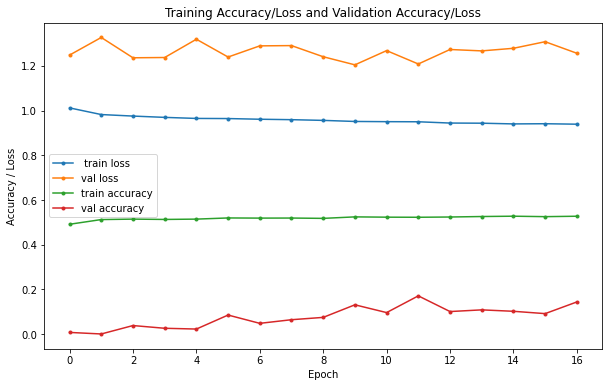

120/120 [==============================] - 0s 2ms/step - loss: 0.9385 - acc: 0.5413
Test Loss: 0.938530445098877
Test Accuracy: 0.5413060784339905
               precision    recall  f1-score   support

Breaking Ball       0.38      0.18      0.24      1182
     Fastball       0.57      0.87      0.69      2121
    Off-speed       0.37      0.03      0.06       510

     accuracy                           0.54      3813
    macro avg       0.44      0.36      0.33      3813
 weighted avg       0.49      0.54      0.47      3813

INFO:tensorflow:Assets written to: saved_model/degrom\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


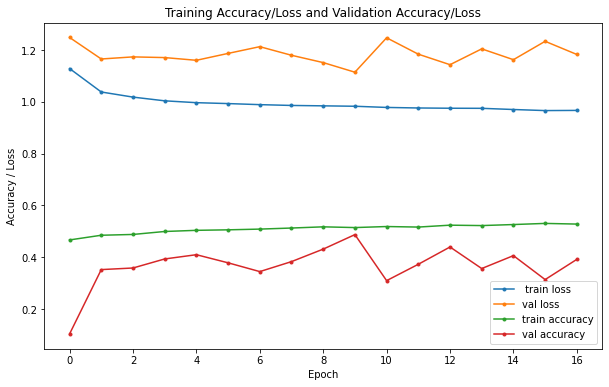

125/125 [==============================] - 0s 1ms/step - loss: 0.9851 - acc: 0.5028
Test Loss: 0.9851406812667847
Test Accuracy: 0.5027638077735901


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.44      0.41      0.42      1227
     Fastball       0.56      0.64      0.60      1963
         Junk       0.00      0.00      0.00        34
    Off-speed       0.41      0.33      0.37       756

     accuracy                           0.50      3980
    macro avg       0.35      0.34      0.35      3980
 weighted avg       0.49      0.50      0.49      3980

INFO:tensorflow:Assets written to: saved_model/greinke\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


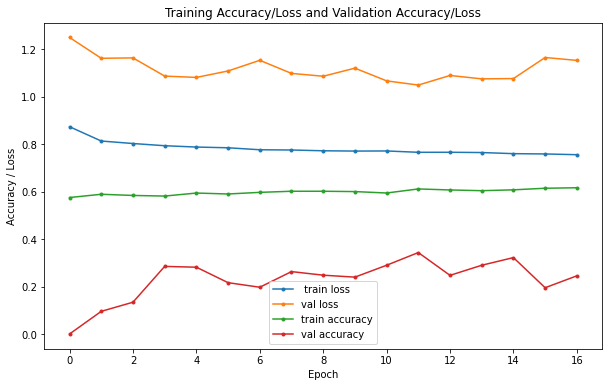

108/108 [==============================] - 0s 1ms/step - loss: 0.7541 - acc: 0.6026
Test Loss: 0.7541336417198181
Test Accuracy: 0.6026086807250977


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.43      0.28      0.34      1136
     Fastball       0.65      0.82      0.72      2158
    Off-speed       0.00      0.00      0.00       156

     accuracy                           0.60      3450
    macro avg       0.36      0.37      0.35      3450
 weighted avg       0.55      0.60      0.56      3450

INFO:tensorflow:Assets written to: saved_model/bumgarner\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


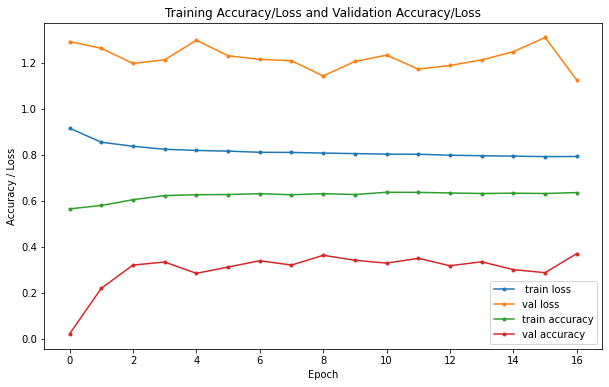

93/93 [==============================] - 0s 1ms/step - loss: 0.7671 - acc: 0.6632
Test Loss: 0.767118513584137
Test Accuracy: 0.6631614565849304
               precision    recall  f1-score   support

Breaking Ball       0.44      0.46      0.45       799
     Fastball       0.75      0.80      0.77      1985
    Off-speed       1.00      0.01      0.01       164

     accuracy                           0.66      2948
    macro avg       0.73      0.42      0.41      2948
 weighted avg       0.68      0.66      0.64      2948

INFO:tensorflow:Assets written to: saved_model/stroman\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


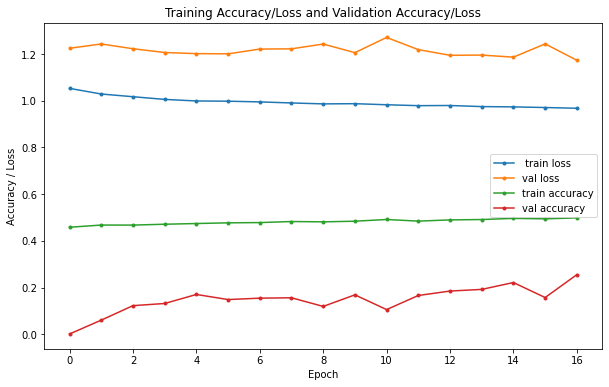

121/121 [==============================] - 0s 1ms/step - loss: 0.9670 - acc: 0.4883
Test Loss: 0.9670016765594482
Test Accuracy: 0.48834195733070374
               precision    recall  f1-score   support

Breaking Ball       0.39      0.26      0.31      1148
     Fastball       0.54      0.72      0.61      1944
    Off-speed       0.39      0.24      0.30       768

     accuracy                           0.49      3860
    macro avg       0.44      0.41      0.41      3860
 weighted avg       0.46      0.49      0.46      3860

INFO:tensorflow:Assets written to: saved_model/sale\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


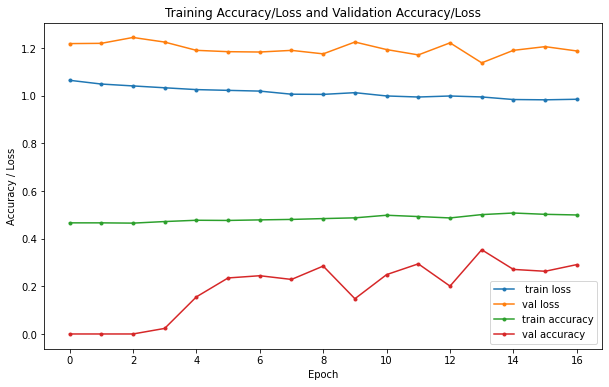

51/51 [==============================] - 0s 1ms/step - loss: 0.9757 - acc: 0.4994
Test Loss: 0.9756975769996643
Test Accuracy: 0.4993857443332672
               precision    recall  f1-score   support

Breaking Ball       0.30      0.07      0.11       270
     Fastball       0.61      0.65      0.63       958
    Off-speed       0.31      0.42      0.36       400

     accuracy                           0.50      1628
    macro avg       0.41      0.38      0.37      1628
 weighted avg       0.49      0.50      0.48      1628

INFO:tensorflow:Assets written to: saved_model/ryu\assets


In [771]:
for name in player_list:
    kershaw = df[df['player_name']==name]

    # Drop rows / intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
    kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['pitch_name']=='Other'].index, inplace=True, errors = 'ignore')

    # Also rows w/ drop the corresponding rows that contain them as a previous pitch
    kershaw.drop(kershaw[kershaw['prev_pitch']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['prev_pitch']=='Pitch Out'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['prev_pitch']=='Other'].index, inplace=True, errors = 'ignore')

    # Drop any rows w/ invalid values that may have slipped through
    # balls > 3 or strikes > 2 means the at-bat is over
    # outs > 2 means the inning is over
    kershaw.drop(kershaw[kershaw['balls'] > 3].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['strikes'] > 2].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['outs_when_up']> 2].index, inplace=True, errors = 'ignore')
    
    
    # Unable to classify/do regression with classes with only 1 instance
    # so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
    for i in range(len(kershaw['pitch_name'].value_counts())):
        if kershaw['pitch_name'].value_counts()[i] == 1:
            drop = kershaw['pitch_name'].value_counts().index[i]
            kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
            kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

    kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

    # Don't need pitcher handedness in this, the variance of the columns will be 0
    kershaw.drop(['p_left', 'p_right'], axis = 1, inplace = True)

    # Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
    kershaw.drop(['release_speed'], axis = 1, inplace = True)

    # Drop other non pre-pitch predicative stuff
    kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)

    kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

    balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')

    strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')

    prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

    outs = pd.get_dummies(kershaw['outs_when_up'], prefix = 'o_')

    X = pd.concat([kershaw, balls, strikes, outs, prev], axis = 1)

    # Drop the original columns
    X.drop(['balls', 'strikes', 'outs_when_up', 'prev_pitch'], axis = 1, inplace = True)

    # X.drop(['pitch_name'], axis = 1, inplace = True)

    X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

    X['early'] = np.where(X['inning'] <= 3, 1, 0)
    X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
    X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)

    X.drop(['inning'], axis = 1, inplace = True)

    X.drop(['pitch_number'], axis = 1, inplace = True)

    X.drop(['zone'], axis = 1, inplace = True)

    X1 = X.drop(['pitch_name'], axis = 1)
    y = X['pitch_name']


    # Split with stratification given the class imbalance
    X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25, random_state=123)
    y_test_copy = y_test.copy()

    train = pd.concat([X_train, y_train], axis =1)

    df_major =  train[train['pitch_name']==train['pitch_name'].value_counts().index[0]]
    df_rest = train[train['pitch_name']!=train['pitch_name'].value_counts().index[0]]

    df_down = resample(df_major, 
                          replace=True, 
                          n_samples = train['pitch_name'].value_counts().values[1], 
                          random_state=123)


    df_downsampled = pd.concat([df_down, df_rest])

    X_train = df_downsampled.drop(['pitch_name'], axis = 1)

    y_train = df_downsampled['pitch_name']

    # Convert output to an array
    pitch = pd.get_dummies(y_train.copy())
    y_train = pitch.values

    pitch = pd.get_dummies(y_test.copy())
    y_test = pitch.values

    # Best performing one so far
    opt = tf.keras.optimizers.Adam(lr=0.0001)

    # Make sure to reset model before running each time
    input_layer = Input(shape = (X_train.shape[1], ))
    dense_layer_1 = Dense(512, activation='relu')(input_layer)
    drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
    dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
    drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
    dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
    drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
    dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
    # Output shape equals to number of classes (columns) in y
    output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    history = model.fit(X_train, y_train, batch_size=25, epochs=17, verbose=0, validation_split=0.2)

    plt.figure(figsize = (10,6))
    plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
    plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
    plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
    plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
    plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.show()

    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    
    predictions = model.predict(X_test)
    pred_pitch = np.argmax(predictions,axis=1)
    actual_pitch = np.argmax(y_test, axis = 1)
    xnames = pitch.columns

    # Convert the array of integers into the pitch names using nested np.where functions
    # For 2 pitch pitchers:
    if max(actual_pitch) == 1:
        actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                                np.where(actual_pitch == 1, xnames.values[1], actual_pitch))

        pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                                np.where(pred_pitch == 1, xnames.values[1], pred_pitch))
    elif max(actual_pitch) == 2:
        # For 3 pitch pitchers:
        actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                                np.where(actual_pitch == 1, xnames.values[1], 
                                         np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

        pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                                np.where(pred_pitch == 1, xnames.values[1], 
                                         np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))
    elif max(actual_pitch) == 3:
        # For 4 pitch pitchers:    
        actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                                np.where(actual_pitch == 1, xnames.values[1], 
                                         np.where(actual_pitch == 2, xnames.values[2], 
                                                  np.where(actual_pitch == 3, xnames.values[3], actual_pitch))))

        pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                                np.where(pred_pitch == 1, xnames.values[1], 
                                         np.where(pred_pitch == 2, xnames.values[2], 
                                                  np.where(pred_pitch == 3, xnames.values[3], pred_pitch))))


    report_initial = classification_report(actual_pitch, pred_pitch)
    print(report_initial)

    lastname = name.split()[1].lower()
    model.save(f'saved_model/{lastname}') 

***
### Lastly, what I wanted to do was to get the test accuracy scores for each player and plot them to see how they vary player to player.

The pipeline is the same as above but again, complied into a single cell and made to be scaleable. This is important practice to make sure my eventual script will be able to run as well.

In [805]:
# Get test scores of each model/for each player and append them to a list

test_scores = []
for name in player_list:
    # Get the last name from the full name in lower case
    lastname = name.split()[1].lower()

    # Load the correct model
    model = tf.keras.models.load_model(f'saved_model/{lastname}')
    kershaw = df[df['player_name']==name]

    # Drop rows / intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
    kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['pitch_name']=='Other'].index, inplace=True, errors = 'ignore')

    # Also rows w/ drop the corresponding rows that contain them as a previous pitch
    kershaw.drop(kershaw[kershaw['prev_pitch']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['prev_pitch']=='Pitch Out'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['prev_pitch']=='Other'].index, inplace=True, errors = 'ignore')

    # Drop any rows w/ invalid values that may have slipped through
    # balls > 3 or strikes > 2 means the at-bat is over
    # outs > 2 means the inning is over
    kershaw.drop(kershaw[kershaw['balls'] > 3].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['strikes'] > 2].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['outs_when_up']> 2].index, inplace=True, errors = 'ignore')
    
    
    # Unable to classify/do regression with classes with only 1 instance
    # so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
    for i in range(len(kershaw['pitch_name'].value_counts())):
        if kershaw['pitch_name'].value_counts()[i] == 1:
            drop = kershaw['pitch_name'].value_counts().index[i]
            kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
            kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

    kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

    # Don't need pitcher handedness in this, the variance of the columns will be 0
    kershaw.drop(['p_left', 'p_right'], axis = 1, inplace = True)

    # Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
    kershaw.drop(['release_speed'], axis = 1, inplace = True)

    # Drop other non pre-pitch predicative stuff
    kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)

    kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

    balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')

    strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')

    prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

    outs = pd.get_dummies(kershaw['outs_when_up'], prefix = 'o_')

    X = pd.concat([kershaw, balls, strikes, outs, prev], axis = 1)

    # Drop the original columns
    X.drop(['balls', 'strikes', 'outs_when_up', 'prev_pitch'], axis = 1, inplace = True)

    # X.drop(['pitch_name'], axis = 1, inplace = True)

    X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

    X['early'] = np.where(X['inning'] <= 3, 1, 0)
    X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
    X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)

    X.drop(['inning'], axis = 1, inplace = True)

    X.drop(['pitch_number'], axis = 1, inplace = True)

    X.drop(['zone'], axis = 1, inplace = True)

    X1 = X.drop(['pitch_name'], axis = 1)
    y = X['pitch_name']


    # Split with stratification given the class imbalance
    X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25, random_state=123)
    y_test_copy = y_test.copy()

    train = pd.concat([X_train, y_train], axis =1)

    df_major =  train[train['pitch_name']==train['pitch_name'].value_counts().index[0]]
    df_rest = train[train['pitch_name']!=train['pitch_name'].value_counts().index[0]]

    df_down = resample(df_major, 
                          replace=True, 
                          n_samples = train['pitch_name'].value_counts().values[1], 
                          random_state=123)


    df_downsampled = pd.concat([df_down, df_rest])

    X_train = df_downsampled.drop(['pitch_name'], axis = 1)

    y_train = df_downsampled['pitch_name']

    # Convert output to an array
    pitch = pd.get_dummies(y_train.copy())
    y_train = pitch.values

    pitch = pd.get_dummies(y_test.copy())
    y_test = pitch.values
    
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", score[0])
    print(f"{name} Test Accuracy:", score[1])
    test_scores.append(score[1])

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


113/113 [==============================] - 0s 2ms/step - loss: 0.6746 - acc: 0.6187
Test Loss: 0.6746216416358948
Clayton Kershaw Test Accuracy: 0.618691086769104


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


137/137 [==============================] - 0s 1ms/step - loss: 0.7599 - acc: 0.6318
Test Loss: 0.759920060634613
Justin Verlander Test Accuracy: 0.6318327784538269


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


134/134 [==============================] - 0s 3ms/step - loss: 0.8884 - acc: 0.5660
Test Loss: 0.888405978679657
Max Scherzer Test Accuracy: 0.566002368927002


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


105/105 [==============================] - 0s 2ms/step - loss: 0.9600 - acc: 0.5093
Test Loss: 0.959986686706543
Stephen Strasburg Test Accuracy: 0.5092869997024536


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


124/124 [==============================] - 0s 4ms/step - loss: 0.8095 - acc: 0.5966
Test Loss: 0.809485673904419
Gerrit Cole Test Accuracy: 0.5965664982795715


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


120/120 [==============================] - 0s 1ms/step - loss: 0.9385 - acc: 0.5413
Test Loss: 0.938530445098877
Jacob deGrom Test Accuracy: 0.5413060784339905


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


125/125 [==============================] - 0s 2ms/step - loss: 0.9851 - acc: 0.5028
Test Loss: 0.9851406812667847
Zack Greinke Test Accuracy: 0.5027638077735901


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


108/108 [==============================] - 0s 1ms/step - loss: 0.7541 - acc: 0.6026
Test Loss: 0.7541336417198181
Madison Bumgarner Test Accuracy: 0.6026086807250977


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


93/93 [==============================] - 0s 1ms/step - loss: 0.7671 - acc: 0.6632
Test Loss: 0.767118513584137
Marcus Stroman Test Accuracy: 0.6631614565849304


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


121/121 [==============================] - 0s 2ms/step - loss: 0.9670 - acc: 0.4883
Test Loss: 0.9670016765594482
Chris Sale Test Accuracy: 0.48834195733070374


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


51/51 [==============================] - 0s 1ms/step - loss: 0.9757 - acc: 0.4994
Test Loss: 0.9756975769996643
Hyun-Jin Ryu Test Accuracy: 0.4993857443332672


In [869]:
# Turn the test scores to a dataframe and sort
scores = pd.DataFrame([player_list, test_scores]).T
scores.columns = ['name', 'test_score']
scores.sort_values(by = 'test_score', ascending = False, inplace = True)
scores

,name,test_score
8,Marcus Stroman,0.663161
1,Justin Verlander,0.631833
0,Clayton Kershaw,0.618691
7,Madison Bumgarner,0.602609
4,Gerrit Cole,0.596566
2,Max Scherzer,0.566002
5,Jacob deGrom,0.541306
3,Stephen Strasburg,0.509287
6,Zack Greinke,0.502764
10,Hyun-Jin Ryu,0.499386


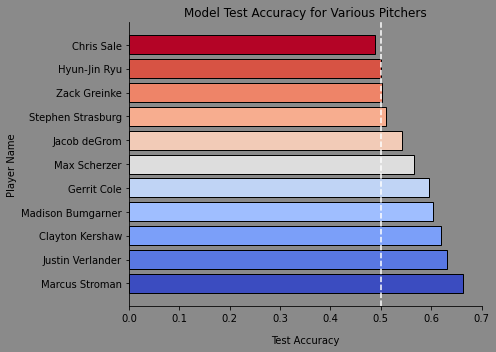

In [893]:
# Create a plot showing the model accuracies for the different pitchers

# Plot the test scores for each player in a bar graph
fig, ax = plt.subplots(figsize=(7,5))
# Set the color scheme of the bars using the coolwarm gradient across the number of players
cmap=plt.get_cmap('coolwarm', len(scores))
# Plot bars
ax.barh(scores['name'], scores['test_score'], edgecolor = 'black', color = cmap(range(len(scores))))
# Axis labels
ax.set_xlabel('Test Accuracy', labelpad = 12)
ax.set_ylabel('Player Name')
# Scores don't have a large range so set the range of the plot from 0 to the highest test score rounded to nearest 10
ax.set_xlim(0, round(scores['test_score'].max(), 1))
# Set background colour
fig.patch.set_facecolor('#8a8a8a')
# Set face color
ax.set_facecolor('#8a8a8a')
# Remove some spines for aesthetics
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
# Title
ax.set_title('Model Test Accuracy for Various Pitchers')
# Draw a line at 50%
ax.axvline(0.5, color = 'white', linewidth = 1.5, linestyle = '--')
# Formatting
plt.tight_layout()
# Save
plt.savefig('C:/Users/Boyang Qiu/Desktop/Brainstation/Capstone/static/staticplots/acc.png', facecolor=fig.get_facecolor())
plt.show()

***